In [1]:
import pandas as pd
import re
import nltk
import torch
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Load the data
train_df = pd.read_csv("Train.csv")
valid_df = pd.read_csv("Valid.csv")
test_df = pd.read_csv("Test.csv")

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Removing punctuation
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply preprocessing to the text data
train_df['preprocessed_text'] = train_df['text'].apply(preprocess_text)
valid_df['preprocessed_text'] = valid_df['text'].apply(preprocess_text)
test_df['preprocessed_text'] = test_df['text'].apply(preprocess_text)

In [4]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(train_df['preprocessed_text'])
X_valid_vec = vectorizer.transform(valid_df['preprocessed_text'])
X_test_vec = vectorizer.transform(test_df['preprocessed_text'])
y_train = train_df['label']
y_valid = valid_df['label']

In [ ]:
X_train_vec

<40000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2217505 stored elements in Compressed Sparse Row format>

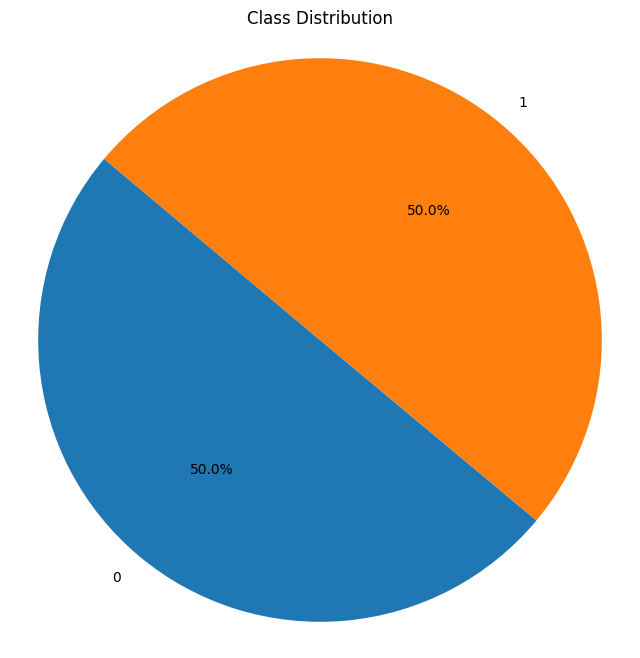

In [ ]:
import matplotlib.pyplot as plt

# Calculate class distribution
class_distribution = y_train.value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution')
plt.show()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               40000 non-null  object
 1   label              40000 non-null  int64 
 2   preprocessed_text  40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Train and evaluate Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_vec, y_train)
logreg_preds_valid = logreg_model.predict(X_valid_vec)
logreg_accuracy = accuracy_score(y_valid, logreg_preds_valid)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, logreg_preds_valid)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision
precision = precision_score(y_valid, logreg_preds_valid)
print("Precision:", precision)

# Compute recall
recall = recall_score(y_valid, logreg_preds_valid)
print("Recall:", recall)

Logistic Regression Accuracy: 0.8882
Confusion Matrix:
[[2164  322]
 [ 237 2277]]
Precision: 0.8761061946902655
Recall: 0.905727923627685


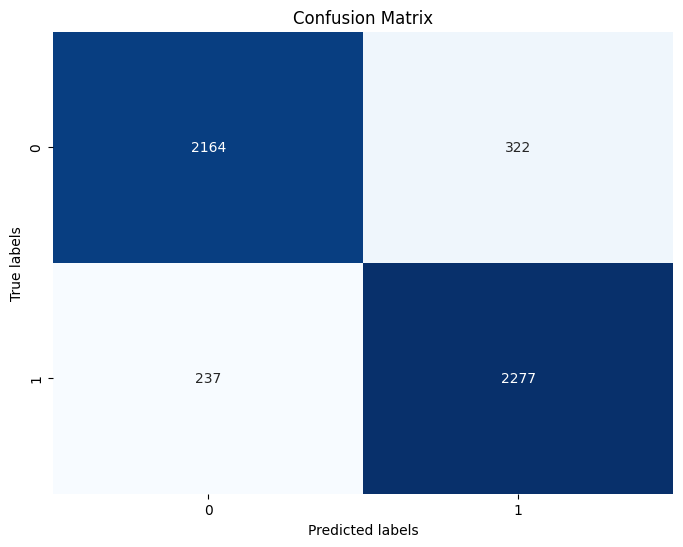

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# Train and evaluate Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds_valid = nb_model.predict(X_valid_vec)
nb_accuracy = accuracy_score(y_valid, nb_preds_valid)
print("Naive Bayes Accuracy:", nb_accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, nb_preds_valid)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision
precision = precision_score(y_valid, nb_preds_valid)
print("Precision:", precision)

# Compute recall
recall = recall_score(y_valid, nb_preds_valid)
print("Recall:", recall)


Naive Bayes Accuracy: 0.8572
Confusion Matrix:
[[2129  357]
 [ 357 2157]]
Precision: 0.8579952267303103
Recall: 0.8579952267303103


In [11]:
# Train and evaluate Support Vector Machine (SVM) model
svm_model = SVC()
svm_model.fit(X_train_vec, y_train)
svm_preds_valid = svm_model.predict(X_valid_vec)
svm_accuracy = accuracy_score(y_valid, svm_preds_valid)
print("SVM Accuracy:", svm_accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, svm_preds_valid)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision
precision = precision_score(y_valid, svm_preds_valid)
print("Precision:", precision)

# Compute recall
recall = recall_score(y_valid, svm_preds_valid)
print("Recall:", recall)


SVM Accuracy: 0.8936
Confusion Matrix:
[[2177  309]
 [ 223 2291]]
Precision: 0.8811538461538462
Recall: 0.911296738265712


In [12]:
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_vec, y_train)
rf_preds_valid = rf_model.predict(X_valid_vec)
rf_accuracy = accuracy_score(y_valid, rf_preds_valid)
print("Random Forest Accuracy:", rf_accuracy)


# Compute confusion matrix
conf_matrix = confusion_matrix(y_valid, rf_preds_valid)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision
precision = precision_score(y_valid, rf_preds_valid)
print("Precision:", precision)

# Compute recall
recall = recall_score(y_valid, rf_preds_valid)
print("Recall:", recall)



Random Forest Accuracy: 0.8506
Confusion Matrix:
[[2111  375]
 [ 372 2142]]
Precision: 0.8510131108462455
Recall: 0.8520286396181385


In [13]:
# Train and evaluate BERT model
class CustomDatasetTrain(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }




In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256
batch_size = 32

train_dataset = CustomDatasetTrain(train_df['preprocessed_text'].values, train_df['label'].values, tokenizer, max_len)
valid_dataset = CustomDatasetTrain(valid_df['preprocessed_text'].values, valid_df['label'].values, tokenizer, max_len)
test_dataset = CustomDatasetTrain(test_df['preprocessed_text'].values, test_df['label'].values, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def train_epoch(model, data_loader, optimizer, device):
    i=0
    model.train()
    losses = []
    correct_predictions = 0
    print(len(data_loader))
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"....... {i}")
        i = i+1

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

num_epochs = 3

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    valid_acc, _ = eval_model(model, valid_loader, device)
    print(f'Validation Accuracy: {valid_acc:.4f}')


1250
....... 0
....... 1
....... 2
....... 3
....... 4
....... 5
....... 6
....... 7
....... 8
....... 9
....... 10
....... 11
....... 12
....... 13
....... 14
....... 15
....... 16
....... 17
....... 18
....... 19
....... 20
....... 21
....... 22
....... 23
....... 24
....... 25
....... 26
....... 27
....... 28
....... 29
....... 30
....... 31
....... 32
....... 33
....... 34
....... 35
....... 36
....... 37
....... 38
....... 39
....... 40
....... 41
....... 42
....... 43
....... 44
....... 45
....... 46
....... 47
....... 48
....... 49
....... 50
....... 51
....... 52
....... 53
....... 54
....... 55
....... 56
....... 57
....... 58
....... 59
....... 60
....... 61
....... 62
....... 63
....... 64
....... 65
....... 66
....... 67
....... 68
....... 69
....... 70
....... 71
....... 72
....... 73
....... 74
....... 75
....... 76
....... 77
....... 78
....... 79
....... 80
....... 81
....... 82
....... 83
....... 84
....... 85
....... 86
....... 87
....... 88
....... 89
....... 90
....

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Define a function to get predictions for the validation set
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_preds, all_labels

# Get predictions for the validation set
val_preds, val_labels = get_predictions(model, valid_loader, device)

# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Compute precision
precision = precision_score(val_labels, val_preds)
print("Precision:", precision)

# Compute recall
recall = recall_score(val_labels, val_preds)
print("Recall:", recall)


Confusion Matrix:
[[2218  268]
 [ 186 2328]]
Precision: 0.8967642526964561
Recall: 0.9260143198090692


In [17]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch

# Define your model class here if not already defined

# Define a custom dataset class to load the test data
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long)
        }

# Load the test data from the CSV file
test_data = pd.read_csv('Test.csv')

# Define the parameters
max_length = 256  # Adjust this according to your model's maximum input length
batch_size = 32  # Adjust batch size based on your system's memory

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create a DataLoader for the test data
test_dataset = CustomDataset(test_data, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Assuming your model is already defined and loaded, proceed with making predictions
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        test_preds.extend(preds.cpu().tolist())

# Add the predicted labels to the test DataFrame
test_data['label'] = test_preds

# Save the results to a submission file
test_data[['id', 'label']].to_csv('submission.csv', index=False)